In [3]:
library(tidyverse)
library(nhanesA)
options(repr.plot.width=10, repr.plot.height=6)
theme_set(theme_classic())

# STATS 504
## Week 9: Causal inference

### Smoking and lung cancer: observational data

In [4]:
demo <- nhanes("DEMO_J")
mcq <- nhanes("MCQ_J")
smq <- nhanes("SMQ_J")

In [51]:
# nhanesCodebook("MCQ", "MCQ230A")
table(mcq$MCQ230A)


                    Bladder                       Blood 
                         12                           1 
                       Bone                       Brain 
                          1                           4 
                     Breast           Cervix (cervical) 
                         89                          26 
                      Colon      Esophagus (esophageal) 
                         46                           6 
                Gallbladder                      Kidney 
                          1                          19 
           Larynx/ windpipe                    Leukemia 
                          1                           6 
                      Liver                        Lung 
                          3                          18 
Lymphoma/ Hodgkin's disease                    Melanoma 
                         15                          35 
           Mouth/tongue/lip             Ovary (ovarian) 
                          4   

In [20]:
nhanesCodebook("SMQ", "SMQ020")

Code or Value,Value Description,Count,Cumulative,Skip to Item
<chr>,<chr>,<int>,<int>,<chr>
1,Yes,2299,2299,
2,No,2566,4865,SMQ120
7,Refused,4,4869,SMQ120
9,Don't know,8,4877,SMQ120
.,Missing,3,4880,


In [53]:
mcq %>% filter(MCQ230A == "Lung") %>% left_join(smq) %>% xtabs(~ SMQ020, data = .)

Joining with `by = join_by(SEQN)`


SMQ020
Yes  No 
 17   1 

In [35]:
demo %>% left_join(mcq) %>% mutate(lung_cancer = MCQ230A == "Lung") %>% 
    replace_na(list(lung_cancer = F)) %>% 
    xtabs(~ INDHHIN2 + lung_cancer, data = .) %>% 
    prop.table(2) %>% 
    round(2)

Joining with `by = join_by(SEQN)`


                    lung_cancer
INDHHIN2             FALSE TRUE
  $ 0 to $ 4,999      0.03 0.00
  $ 5,000 to $ 9,999  0.03 0.00
  $10,000 to $14,999  0.05 0.12
  $15,000 to $19,999  0.06 0.12
  $20,000 to $24,999  0.06 0.06
  $25,000 to $34,999  0.11 0.29
  $35,000 to $44,999  0.10 0.12
  $45,000 to $54,999  0.07 0.06
  $55,000 to $64,999  0.07 0.00
  $65,000 to $74,999  0.05 0.06
  $20,000 and Over    0.04 0.00
  Under $20,000       0.01 0.12
  $75,000 to $99,999  0.09 0.00
  $100,000 and Over   0.19 0.06
  Refused             0.02 0.00
  Don't know          0.03 0.00

## Causal inference
- $T_i$ is the "treatment" for person $i$, e.g. "smokes".
- $Y_i$ is the "outcome" for person $i$, e.g. "gets lung cancer".
- Potential outcomes:
    - $Y_i(1)$ is the outcome for person $i$ if they were given the treatment.
    - $Y_i(0)$ is the outcome for person $i$ if they were not given the treatment.
- $Y_i = T_i Y_i(1) + (1 - T_i) Y_i(0).$

## Average treatment effect
- We'd like to be able to estimate the average treatment effect:

$$\text{ATE} = \mathbb{E}[Y_i(1) - Y_i(0)]$$

- "How much on average does switching from smoker to nonsmoker raise your risk of getting lung cancer?"


## Fundamental problem of causal inference


- **We only observe $Y_i(1)$ for people who got the treatment. We only observe $Y_i(0)$ for people who did not get the treatment.**

- Thus, 

    $$\frac{1}{n_\text{smokers}} \sum_{i \in \text{smokers}} Y_i$$ is in general *not* a consistent estimator of 
    $\mathbb{E}Y_i(1)$.
    
- And similarly for $Y_i(0)$.

## Cholera in 19th century England
- Cholera first arrived to England in 1831.

- 31,000 people died of cholera between 1831-1832.

- A second outbreak in 1848 killed 62,000.

![father thames](https://scpoecon.github.io/ScPoEconometrics/images/father-thames.jpg)

Source: Punch (1858), cited in https://scpoecon.github.io/ScPoEconometrics/IV.html.

![cholera charicature](https://www.sciencemuseum.org.uk/sites/default/files/styles/smg_carousel_zoom/public/2065329612.jpg)

Source: https://www.sciencemuseum.org.uk/objects-and-stories/medicine/cholera-victorian-london

## What causes Cholera?

- Germs had not yet been discovered, and were only one (unpopular) theory.

* Miasmas (poisonous particles floating in the air):
    - Rapid industrialisation created filthy, unsanitary neighborhoods that tended to be the focal points of disease and epidemics.
    - By improving sanitation and cleanliness, levels of disease were seen to fall, which seemed to support the miasma theory.

- Other theories
    * Imbalances in the humors of the body (black bile, yellow bile, blood, phlegm)
    * Poison in the ground

<img src="images/advice.jpg" width="80%">

## John Snow

* John Snow was a physician in London who, by watching the course of the disease, came to believe believe that Cholera was caused by a living organism that is ingested (with water or food), multiplies within the body, and is expelled back into the environment.</li>

* Snow developed arguments to support his theory, for example:
  * Cholera spreads along trading routes
  * When sailors went somewhere with Cholera, they wouldn't get sick if no one left the boat.

* Nonetheless, there remained considerable skepticism.

<img src="https://upload.wikimedia.org/wikipedia/en/3/30/Jon_Snow_Season_8.png" style="float: right" width=300/>

## John Snow

* John Snow was a physician in London who, by watching the course of the disease, came to believe believe that Cholera was caused by a living organism that is ingested (with water or food), multiplies within the body, and is expelled back into the environment.</li>

* Snow developed arguments to support his theory, for example:
  * Cholera spreads along trading routes
  * When sailors went somewhere with Cholera, they wouldn't get sick if no one left the boat.

* Nonetheless, there remained considerable skepticism.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/John_Snow.jpg/1200px-John_Snow.jpg" style="float: right" width=300/>

## Epidemic of 1854

<img src="images/map.jpg" width="80%">

## Snow's methodology

* Snow identified the first case in London: a man named John Harnold

* Snow also identified the second case: the man who took Harnold's room after Harnold died.

* John Harnold had newly arrived by the *Elbe* steamer from Hamburg, where there was an outbreak.

* Snow also found several adjacent apartment buildings, with one hit by cholera, one not.  He showed that in each case, the affected building had water contaminated by sewage, but the other building had relatively pure water.

### Exceptions

* There was a brewery near the pump, but none of the workers got sick -- it turned out the brewery had its own private pump on-site.

* A woman in Hampstead got Cholera -- Snow discovered that she had water from the Broad Street pump delivered to her, because she liked the taste.

According to legend, Snow lobbied the local council to remove the pump handle, at which time the epidemic receded.

![Removal of the Broad Street pump handle](https://scpoecon.github.io/ScPoEconometrics/ScPoEconometrics_files/figure-html/snow-TS-1.png)

(Cited in: https://scpoecon.github.io/ScPoEconometrics/IV.html)

![broad street pump](https://i0.wp.com/livinglondonhistory.com/wp-content/uploads/2022/07/Optimized-IMG_2622.jpg?w=800&ssl=1)

(Source: https://livinglondonhistory.com/the-story-of-the-john-snow-pump-in-soho/)

## A natural experiment

> Although the facts shown in the above table afford very strong evidence of the powerful influence which the drinking of water containing the sewage of a town exerts over the spread of cholera, when that disease is present, **yet the question does not end here**; for the intermixing of the water supply of the Southwark and Vauxhall Company with that of the Lambeth Company, over an extensive part of London, admitted of the subject being sifted in such a way as to yield the most incontrovertible proof on one side or the other.  In the subdistricts enumerated in the above table as being supplied by both Companies, the mixing of the supply is of the most intimate kind.  The pipes of each Company go down all the streets, and into nearly all the courts and alleys.  **A few houses are supplied by one Company and a few by the other**, according to the decision of the owner or occupier at that time when the Water Companies were in active competition.  In many cases a single house has a supply different from that on either side.  **Each company supplies both rich and poor, both large houses and small**; there is no difference either in the condition or occupation of the persons receiving the water of the different Companies.

![sno's map of water supply](https://scpoecon.github.io/ScPoEconometrics/images/snow-supply.jpg)


(Cited in: https://scpoecon.github.io/ScPoEconometrics/IV.html)

## Snow's reasoning

* There were several water companies in London, and their service areas overlapped.

* On a single street, some people would have one company, others another company.

* The pipes had been laid many years before, when the water companies were still in active competition.

* In 1852, one of the companies (Lambeth) moved its intake pipe upstream to get purer water

* Snow compared the death rates between those who got water from Lambeth, and those who got water from Southwark and Vauxhall

## Snow's data
<div class="xtable"><table frame="hsides" rules="groups" class="rendered small default_table"><thead><tr><th rowspan="1" colspan="1">Water Supply Company</th><th rowspan="1" colspan="1">Number of Houses</th><th rowspan="1" colspan="1">Deaths From Cholera</th><th rowspan="1" colspan="1">Cholera Deaths per 10,000 Houses</th></tr></thead><tbody><tr><td rowspan="1" colspan="1">Southwark and Vauxhall</td><td rowspan="1" colspan="1">40,046</td><td rowspan="1" colspan="1">1,263</td><td rowspan="1" colspan="1">315</td></tr><tr><td rowspan="1" colspan="1">Lambeth</td><td rowspan="1" colspan="1">26,107</td><td rowspan="1" colspan="1">98</td><td rowspan="1" colspan="1">37</td></tr><tr><td rowspan="1" colspan="1">Rest of London</td><td rowspan="1" colspan="1">256,423</td><td rowspan="1" colspan="1">1,422</td><td rowspan="1" colspan="1">59</td></tr></tbody></table></div>

In [60]:
# test of significance
library(causaldata)
data(snow)
snow
# xtabs(~ supplier + treatment, data = snow, weights = deathrate)

year,supplier,treatment,deathrate
<dbl>,<chr>,<chr>,<dbl>
1849,Non-Lambeth Only,Dirty,134.9
1849,Lambeth + Others,Mix Dirty and Clean,130.1
1854,Non-Lambeth Only,Dirty,146.6
1854,Lambeth + Others,Mix Dirty and Clean,84.9


ERROR: Error in xtabs(~supplier + treatment, data = snow, weights = deathrate): unused argument (weights = deathrate)


## Snow's analysis in modern terms

- $y_i=1$ if individual $i$ dies of cholera, 0 otherwise.

- $w_i=1$ if $i$'s water supply is impure, 0 otherewise.

- Just compute $\operatorname{cor}(y, w)$?

### As regression
- Equivalently, fit the model: $y_i = \alpha + \beta w_i + u_i$
    - $u_i$ are all the other unobservable factors that influence death (poverty, lifestyle, competing hypotheses like miasma, etc.)
    - $\beta$ is the increase in mortality if $w_i:0\to 1$.
- What could go wrong?

$$\mathbb{E}(y_i \mid w_i=1) - \mathbb{E}(y_i \mid w_i=0) = ?$$

### Second attempt

- Let $z_i=1$ if the person drank water from Southwark/Vauxhall and $z_i=0$ if they drank water from Lambeth.
- Now take expectation with respect to $z_i=1/0$.

$$\mathbb{E}(y_i \mid z_i=1) - \mathbb{E}(y_i \mid z_i=0) = ?$$

### Assumptions

What assumptions did we make (implicitily or explicitly) when deriving this estimator? 

- $\mathbb{E}(w_i \mid z_i=1) \neq \mathbb{E}(w_i \mid z_i=0)$
- $\mathbb{E}(u_i \mid z_i=1) = \mathbb{E}(u_i \mid z_i=0)$
- Water company only affects mortality through water purity.

Concretely, what do these assumptions mean for the data that Snow analyzed?

## Yule on pauperism

- Poverty rates in England increased dramatically during the Victorian era.

- Emerging industrial economy lowered wages, increased population growth, and decreased the prospects for stable employment.

### Victorian poor houses

- Poor people/"paupers" in England were supported either:
    - Inside “poor-houses”;
    - Outside poor-houses, according to local policy.

- There was a debate about whether poor houses increased or decreased pauperism.

- Yule studied how these policies affected rates of pauperism.

In [47]:
# yule's regression


Call:
lm(formula = paup ~ outrelief + old + pop, data = yule)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.475  -5.311  -1.829   3.132  25.335 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 63.18774   27.14388   2.328   0.0274 *  
outrelief    0.75209    0.13499   5.572 5.83e-06 ***
old          0.05560    0.22336   0.249   0.8052    
pop         -0.31074    0.06685  -4.648 7.25e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.547 on 28 degrees of freedom
Multiple R-squared:  0.6972,	Adjusted R-squared:  0.6647 
F-statistic: 21.49 on 3 and 28 DF,  p-value: 2.001e-07


## Discussion 🙋‍♀️
- Does Yule establish causation or association?
- What sort of factors could confound the causal interpretation?
- Can you think of a way to measure the *causal* effect?

These next example follows Chapter 2 of the book "[Causal Inference in R](https://www.r-causal.org/chapters/02-whole-game)".

## Example: effect of mosquito nets on preventing malaria

- Malaria is a life-threatening disease caused by parasites transmitted to people through the bites of infected female Anopheles gambiae mosquitoes.
- [WHO stats](https://www.who.int/news-room/fact-sheets/detail/malaria): annually,
    - 200-300 million infections worldwide.
    - ~600,000 deaths, with children <5 and pregnant women most vulnerable.
- Predominantly found in sub-Saharan Africa, also south Asia, Middle East, parts of South America.
- Nearly half of all malaria deaths occurred in just six countries: Nigeria (27%), the Democratic Republic of the Congo (12%), Uganda (5%), Mozambique (4%), Angola (3%), and Burkina Faso (3%).

## Insecticide-Treated Mosquito Nets (ITNs)
- Cheap and highly effective prevention method.
- ITNs have been shown to significantly reduce child mortality from all causes by 17% compared to no nets
- Cut the incidence of uncomplicated episodes of Plasmodium falciparum malaria by nearly 50%.
- [Source](https://www.cochrane.org/CD000363/INFECTN_insecticide-treated-nets-preventing-malaria)

## Causal question
- "Does using a bed net reduce the risk of malaria?"

- What do we mean by bed net?
- How do we define risk?
   - Baseline risk level?
   - Death, or just sickness?
   - Risk to whom?

> Does using an ITN compared to no net decrese the risk of contracting malaria after one year?

In [5]:
# library(causalworkshop)
# save(net_data, file="net_data.RData")
load(url("https://github.com/terhorst/stats504/raw/main/lectures/week7/net_data.RData"))

In [6]:
net_data %>% head

id,net,net_num,malaria_risk,income,health,household,eligible,temperature,insecticide_resistance
<int>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
1,FALSE,0,38,779,35,1,FALSE,18.3,38
2,FALSE,0,48,700,35,3,FALSE,18.6,40
3,FALSE,0,32,1083,58,3,FALSE,24.2,70
4,FALSE,0,55,753,68,3,FALSE,19.1,57
5,FALSE,0,36,919,46,5,FALSE,21.2,59
6,FALSE,0,30,969,37,3,FALSE,20.2,49


## About the data
- net: participant used a net (1) or didn’t use a net (0)
- malaria_risk: risk of malaria scale, 0-100
- income: weekly income, USD
- health: health score, 0–100
- household: number of people living in the household
- eligible: 1 if eligible for the free net program.
- temperature: the average temperature at night, in Celsius
- resistance: Insecticide resistance of local mosquitoes, scale 0-100, higher=more resistance.

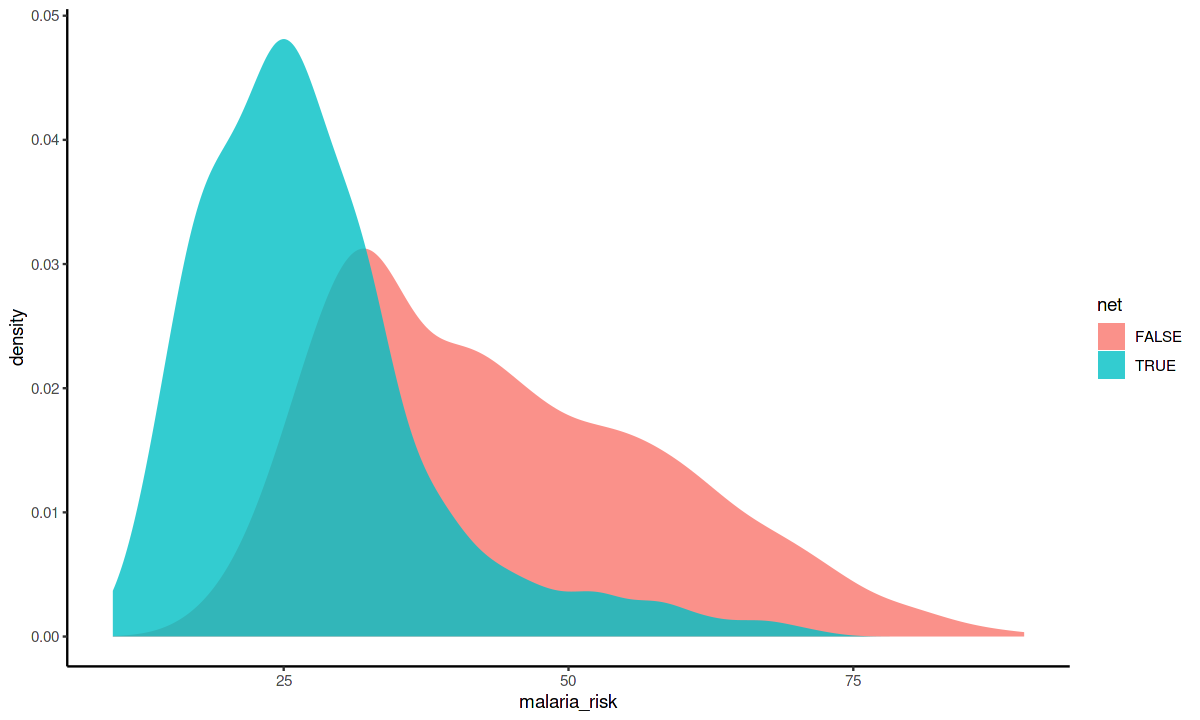

In [7]:
net_data %>% 
  ggplot(aes(malaria_risk, fill = net)) +
  geom_density(color = NA, alpha = .8)

In [8]:
net_data %>% 
  group_by(net) |>
  summarize(malaria_risk = mean(malaria_risk))

net,malaria_risk
<lgl>,<dbl>
FALSE,43.91371
TRUE,27.52863


In [9]:
# Naive regression
lm(malaria_risk ~ net, data = net_data) %>% summary


Call:
lm(formula = malaria_risk ~ net, data = net_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.914 -10.529  -1.914   8.471  46.086 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  43.9137     0.3773   116.4   <2e-16 ***
netTRUE     -16.3851     0.7413   -22.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.59 on 1750 degrees of freedom
Multiple R-squared:  0.2183,	Adjusted R-squared:  0.2178 
F-statistic: 488.6 on 1 and 1750 DF,  p-value: < 2.2e-16


## Causal diagram
Next, we're going to draw a "causal diagram" depicting the relationships between the variables in our data.
- Nodes represent variables
- An edge from node $A$ to node $B$ means that $A$ affects $B$.

![causal diagram](https://www.r-causal.org/chapters/02-whole-game_files/figure-html/fig-net-data-dag-1.png)

What is this graph telling us?
- Risk of malaria is affective by: health, income, using a net, temperature, and resistance to insecticide.
- Net usage is affected by: income, health, eligibility, temperature, and househould size.
- Health is impacted by: income 
- Eligibility is affected by: income and number of people in household.

## Confounding in the graph
- We want to measure the causal impact of mosquito net usage on risk of malaria.
- The trouble is that there are several pathways between these two nodes.
- For example: 

        Net usage <- Eligibility <- Income -> Risk
        Net usage <- Health -> Risk
- So, naively estimating the effect of net usage on risk will pick up a mixture of all of these effects.

Recall the average treatement effect:

$$\text{ATE} = \mathbb{E}_x[Y_1(x) - Y_0(x)]$$

- $Y_0(x)$, $Y_1(x)$ are the potential outcomes for person $x$
- The average is over randomly sample people from the population.
- The regression above suggested $\text{ATE} \approx -16.4$, is this correct?

## Propensity score matching

- Idea is to reweight my observations so that e.g.

$$\mathbb{E}_{x \sim p(x)} Y_1(x) \approx \mathbb{E}_{x \sim p(x \mid T=1)} [w(x) Y(x)] $$

- How should we do this? Use $$w(x) = \frac{\mathbb{P}(T=1)}{\mathbb{P}(T=1 \mid x)}.$$

- Do we know $\mathbb{P}(T=1)$?
- Do we know $\mathbb{P}(T=1 \mid x)$?

In [24]:
propensity_model <- glm(
  net ~ income + health + temperature,
  data = net_data,
  family = binomial()
)

summary(propensity_model)


Call:
glm(formula = net ~ income + health + temperature, family = binomial(), 
    data = net_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1345  -0.8010  -0.6994   1.3284   2.0720  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.9884783  0.4126520  -4.819 1.44e-06 ***
income       0.0019071  0.0004808   3.966 7.29e-05 ***
health      -0.0003234  0.0047099  -0.069   0.9453    
temperature -0.0329793  0.0137158  -2.404   0.0162 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2004.8  on 1751  degrees of freedom
Residual deviance: 1962.0  on 1748  degrees of freedom
AIC: 1970

Number of Fisher Scoring iterations: 4


In [25]:
library(modelr)

net_data %>% add_predictions(propensity_model, type="response") %>% 
    mutate(wt = 1 / (net * pred + (1 - net) * (1 - pred))) ->
    net_data_wts

net_data_wts

id,net,net_num,malaria_risk,income,health,household,eligible,temperature,insecticide_resistance,pred,wt
<int>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FALSE,0,38,779,35,1,FALSE,18.3,38,0.2464385,1.327032
2,FALSE,0,48,700,35,3,FALSE,18.6,40,0.2178480,1.278524
3,FALSE,0,32,1083,58,3,FALSE,24.2,70,0.3230129,1.477133
4,FALSE,0,55,753,68,3,FALSE,19.1,57,0.2307043,1.299890
5,FALSE,0,36,919,46,5,FALSE,21.2,59,0.2789042,1.386778
6,FALSE,0,30,969,37,3,FALSE,20.2,49,0.3060484,1.441023
7,FALSE,0,29,1012,58,1,FALSE,18.9,52,0.3316852,1.496301
8,FALSE,0,45,708,30,2,FALSE,28.8,42,0.1682939,1.202348
9,FALSE,0,51,733,18,3,FALSE,19.9,66,0.2222343,1.285734


## Diagnostics
- The idea of propensity scoring is to weight the observations such that the distribution of confounders is equal between the two groups.
- We can (sort of) check this by visualizing the weighted and unweighted covariates.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


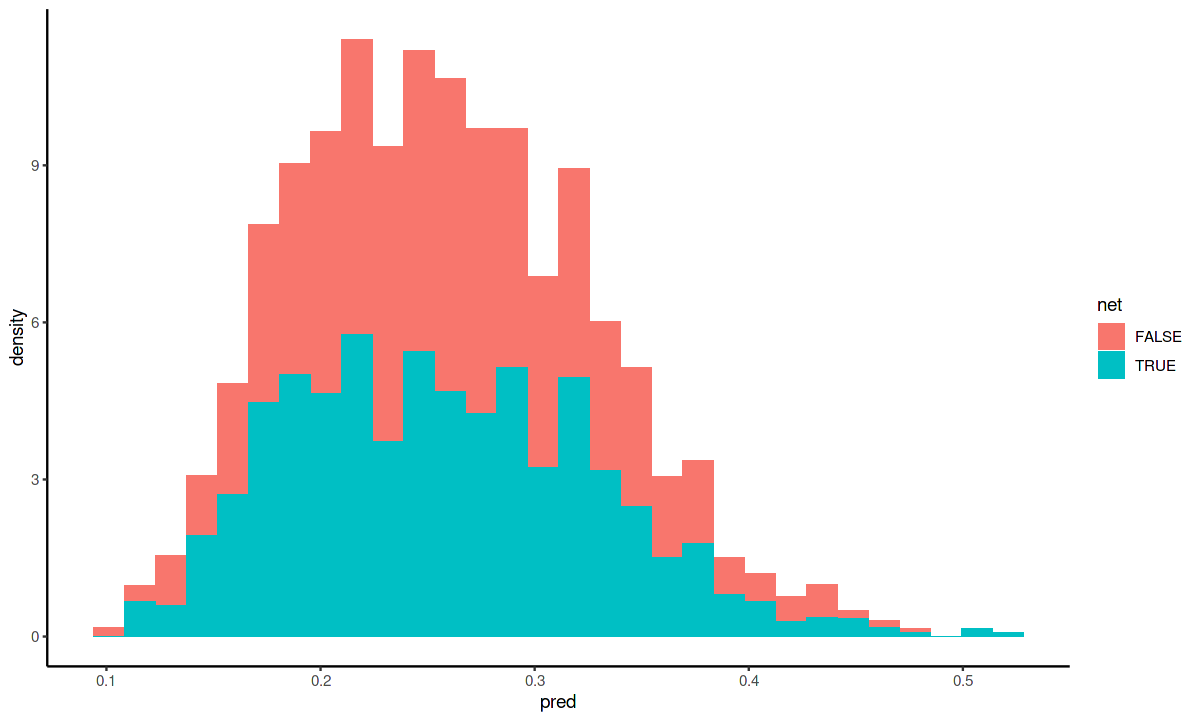

In [26]:
net_data_wts %>% ggplot + geom_histogram(aes(x = pred, y = ..density.., weight=wt, fill=net))

`stat_mirror_count()` using `bins = 30`. Pick better value with `binwidth`.


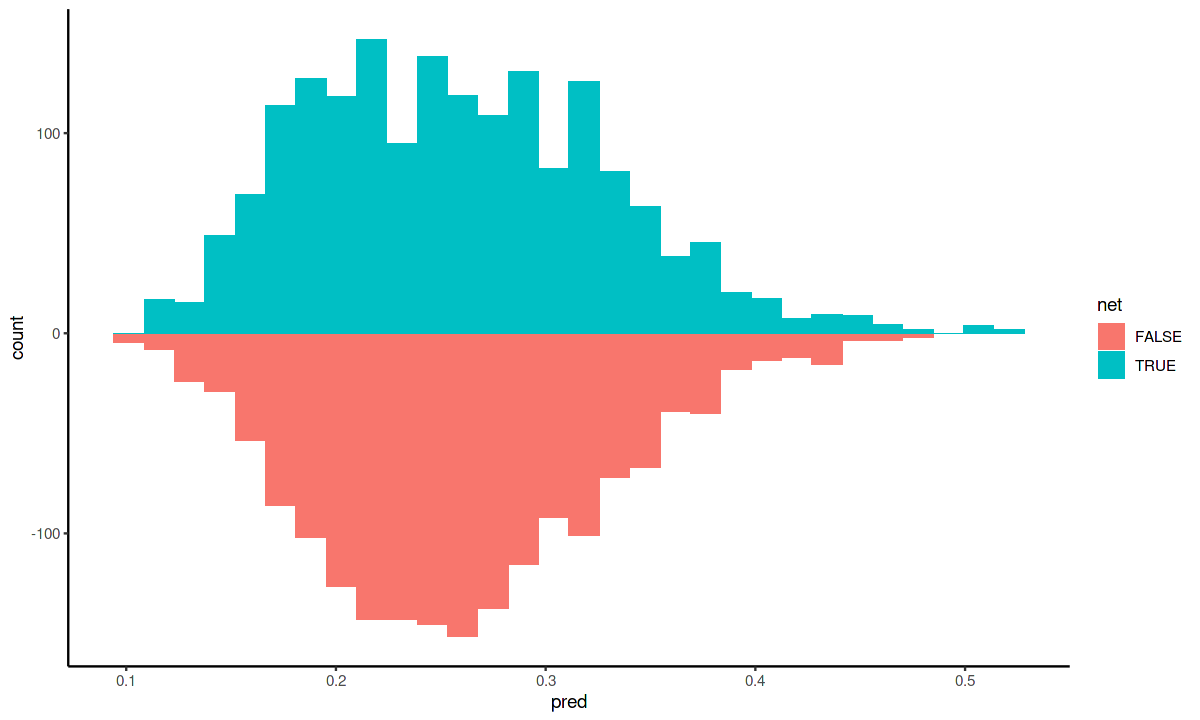

In [27]:
library(halfmoon)
net_data_wts %>% ggplot + geom_mirror_histogram(aes(x = pred, fill = net, weight = wt))

## Covariate balance

- The standardized (mean) difference measures distance between two group means:

$$ \text{SMD} = \frac{\bar{X}_1 - \bar{X}_2}{\sigma_\text{pooled}} $$
- Can be used to measure of covariate balance before and after propensity score matching.
- (After matching, you need to use weighted means and variances of course.)

In [28]:
smd <- function(x1, x2, w1 = NULL, w2 = NULL) {
    n1 <- length(x1)
    n2 <- length(x2)
    mu1 <- Hmisc::wtd.mean(x1, w1)
    mu2 <- Hmisc::wtd.mean(x2, w2)
    v1 <- Hmisc::wtd.var(x1, w1)
    v2 <- Hmisc::wtd.var(x2, w2)
    sd_pooled <- sqrt(((n1 - 1) * v1 + (n2 - 1) * v2) / (n1 + n2 - 2))
    abs(mu1 - mu2) / sd_pooled
}

In [29]:
e <- net_data_wts$net
w <- net_data_wts$wt

smd(net_data_wts$health[e], net_data_wts$health[!e], w[e], w[!e])

[1] 0.01413398

In [30]:
plot_df <- tidy_smd(
  net_data_wts,
  c(income, health, temperature),
  .group = net,
  .wts = wt
)

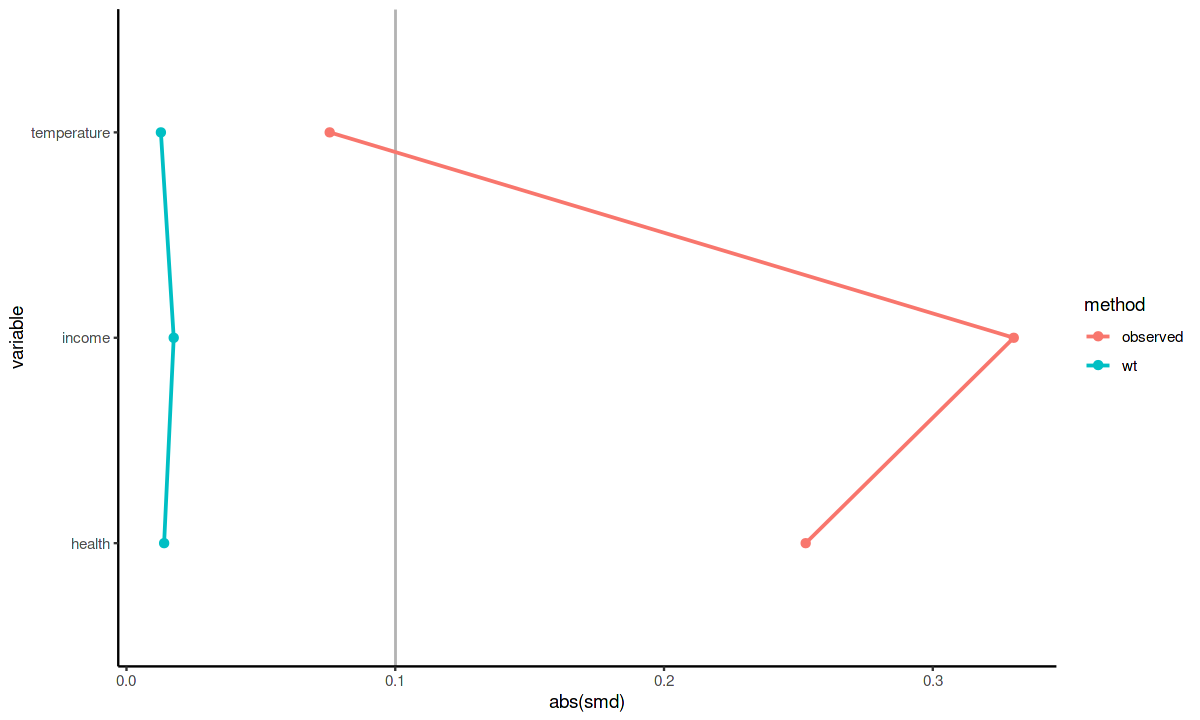

In [31]:
ggplot(plot_df, aes(x=abs(smd), y=variable, group=method, color=method)) + geom_love()

## Estimating the causal effect

Now we can use weighted least squares to estimate the average treatment effect:

In [32]:
library(broom)
net_data_wts %>% 
  lm(malaria_risk ~ net, data = ., weights = wt) %>% 
  tidy(conf.int = T)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),42.73968,0.4420108,96.69376,0.00000e+00,41.87276,43.60661
netTRUE,-12.54476,0.6242525,-20.09565,5.49782e-81,-13.76912,-11.32040


Are there any potential issues with this regression?
- We've used the data twice (how?).
- The weights themselves are random variables and they are not independent.
- The confidence intervals will therefore be to narrow (overconfident).

## Bootstrapping standard errors
- Getting a formula for the correct confidence intervals is difficult (though possible in this case).
- A better solution is to use the bootstrap.

In [33]:
library(rsample)

fit_ipw_1 <- function(split, ...) {
  # get bootstrapped data sample with `rsample::analysis()`
  .df <- analysis(split)

  # fit ipw model
  lm(malaria_risk ~ net, data = .df, weights = wt) %>% 
    tidy()
}

In [34]:
bootstrapped_net_data <- bootstraps(
  net_data_wts,
  times = 1000,
  # required to calculate CIs later
  apparent=T,
)

In [23]:
ipw_results <- bootstrapped_net_data %>% mutate(boot_fits = map(splits, fit_ipw_1))



In [ ]:
ipw_results %>% mutate(estimate = map_dbl(
    boot_fits,
    \(fit) fit %>% filter(term == 'netTRUE') %>% 
    pull(estimate))) %>% 
    ggplot + geom_histogram(aes(x=estimate))

In [22]:
boot_estimates <- ipw_results %>% int_pctl(boot_fits) %>% filter(term == "netTRUE")
boot_estimates

ERROR: Error in int_pctl(., boot_fits): object 'ipw_results' not found


In [30]:
fit_ipw_2 <- function(split, ...) {
  # get bootstrapped data sample with `rsample::analysis()`
  .df <- analysis(split)
    
  # fit propensity model
  propensity_model <- glm(
    net ~ income + health + temperature,
    data = net_data,
    family = binomial()
  )

  .df <- add_predictions(.df, propensity_model, type = "response") %>% 
         mutate(wt = 1 / (net * pred + (1 - net) * (1 - pred)))
    
  # fit ipw model
   lm(malaria_risk ~ net, data = .df, weights = wt) %>% 
    tidy()
}

## Sensitivity analysis
- The above analysis is correct as far is the assumptions we made going in hold.
- What were those assumptions?

Let's suppose we indeed have an unmeasured confounder. We will ask the question:
    
> How much would the confounder have to affect malaria risk before we fail to reject the null?

In [44]:
library(tipr)
tipping_points <- tip_coef(boot_estimates$.upper, exposure_confounder_effect = 1:5)
tipping_points

ℹ The observed effect (-11.09, -11.09, -11.09, -11.09, and -11.09) WOULD be tipped by 1, 1, 1, 1, and 1 unmeasured confounder,
  , , , and with the following specifications:
• estimated difference in scaled means between the unmeasured confounder in the exposed population and unexposed population: 1,
  2, 3, 4, and 5
• estimated relationship between the unmeasured confounder and the outcome: -11.09, -5.55, -3.7, -2.77, and -2.22


effect_observed,exposure_confounder_effect,confounder_outcome_effect,n_unmeasured_confounders
<dbl>,<int>,<dbl>,<dbl>
-11.09166,1,-11.091663,1
-11.09166,2,-5.545832,1
-11.09166,3,-3.697221,1
-11.09166,4,-2.772916,1
-11.09166,5,-2.218333,1


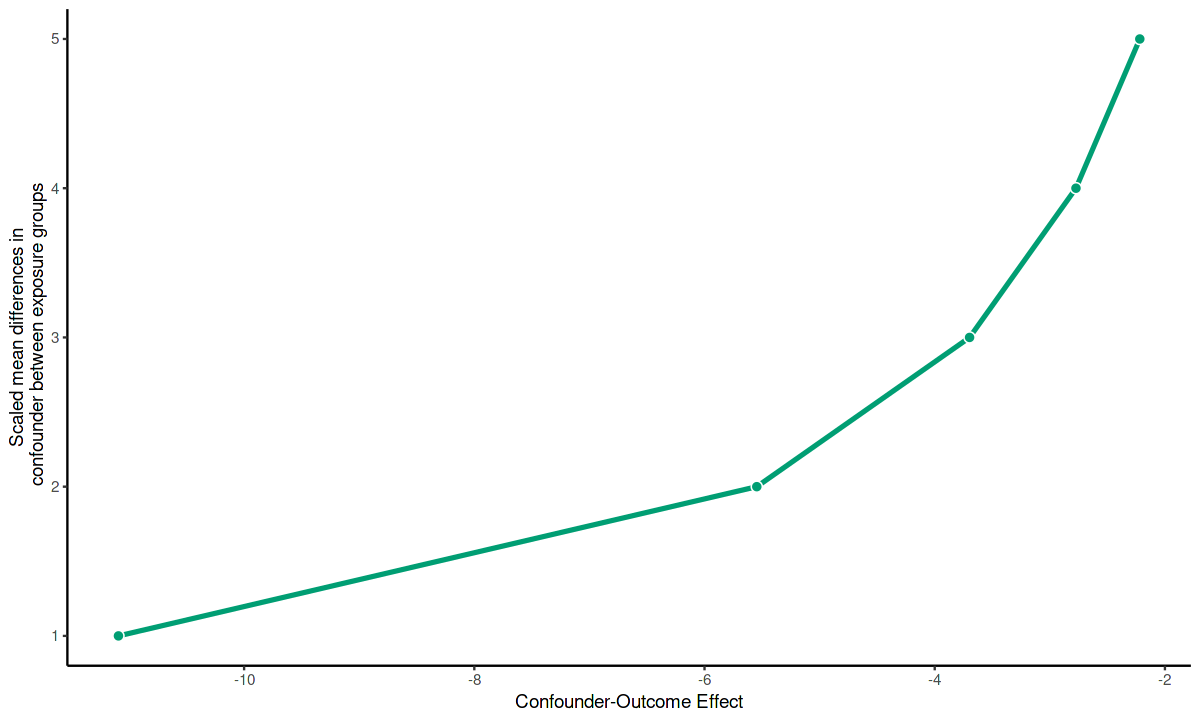

In [47]:
tipping_points %>% 
  ggplot(aes(confounder_outcome_effect, exposure_confounder_effect)) +
  geom_line(color = "#009E73", linewidth = 1.1) +
  geom_point(fill = "#009E73", color = "white", size = 2.5, shape = 21) +
  labs(
    x = "Confounder-Outcome Effect",
    y = "Scaled mean differences in\n confounder between exposure groups"
  )

## Malaria resistance
- Some ethnic group have a genetic resistance to malaria.
- Let’s say that in our simulated data,
  - People with this genetic resistance have, on average, a lower malaria risk by about 10 points.
  - About 26% of people who use nets in our study have this genetic resistance.
  - About 5% of people who don’t use nets have this genetic resistance.

In [48]:
adjusted_estimates <- boot_estimates |>
  select(.estimate, .lower, .upper) |>
  unlist() |>
  adjust_coef_with_binary(
    exposed_confounder_prev = 0.26,
    unexposed_confounder_prev = 0.05,
    confounder_outcome_effect = -10
  )

adjusted_estimates

ℹ The observed effect (-12.54, -14.02, and -11.09) is updated to -10.44, -11.92, and -8.99 by a confounder with the following
  specifications:
• estimated prevalence of the unmeasured confounder in the exposed population: 0.26
• estimated prevalence of the unmeasured confounder in the unexposed population: 0.05
• estimated relationship between the unmeasured confounder and the outcome: -10


effect_adjusted,effect_observed,exposure_confounder_effect,confounder_outcome_effect
<dbl>,<dbl>,<dbl>,<dbl>
-10.438454,-12.53845,0.21,-10
-11.920533,-14.02053,0.21,-10
-8.991663,-11.09166,0.21,-10


![true causal](https://www.r-causal.org/chapters/02-whole-game_files/figure-html/fig-net-data-true-dag-1.png)